In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import HTML

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import json
import matplotlib.pyplot as plt
import os

pandas.options.display.float_format = '{:,.3f}'.format

In [3]:
from evaluate import load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, accession_from_filename, plot_expert_confusion, plot_grad_cam

Using TensorFlow backend.


In [4]:
from data import describe, all_features, data, print_describe
from run import characterize_data

# Uncertain lesions only (c3, c4)

In [5]:
DIRECTORY = "c3-c4-free/data"
FEATURES = "{}/features.csv".format(DIRECTORY)
RAW = "{}/raw".format(DIRECTORY)
TRAIN = "{}/train".format(DIRECTORY)
VALIDATION = "{}/validation".format(DIRECTORY)
MODEL = "/data/intrepidlemon/deep-ultrasound/output2/models/303abda9-4663-4705-88f7-1046bbbe69fa-v2.h5"

## Lesion descriptions

In [6]:
print_describe(raw=RAW, features=FEATURES)

category: C3
	count: 131
	number lesions: 198
	column: feat
		 {'benign': 113, 'malignant': 18}
	column: imag
		 {'biopsy': 6, 'mri': 125}
category: C4
	count: 44
	number lesions: 59
	column: feat
		 {'benign': 10, 'malignant': 34}
	column: imag
		 {'biopsy': 16, 'mri': 28}


In [7]:
train, validation, _ = data(shuffle_train=False, validation_dir=VALIDATION, train_dir=TRAIN)

Found 315 images belonging to 2 classes.
Found 315 images belonging to 2 classes.
Found 245 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [8]:
print("training data breakdown: ", characterize_data(train))
print("validation data breakdown: ", characterize_data(validation))

training data breakdown:  {'benign': 216, 'malignant': 99}
validation data breakdown:  {'benign': 171, 'malignant': 74}


In [9]:
model = load(MODEL)

In [10]:
results = get_results(model, validation)

In [11]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(validation)

## Accuracy and loss

In [12]:
loss, accuracy = calculate_accuracy_loss(model, validation)
print("Accuracy:", accuracy)
print("Loss:", loss)

Accuracy: 0.8163265307338871
Loss: 0.6000292400924527


## Confusion matrix

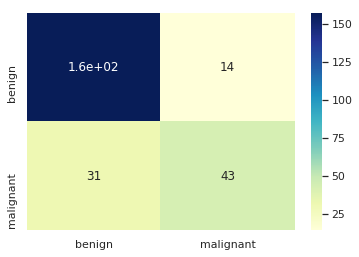

In [13]:
plot_confusion_matrix(validation, results)

In [14]:
stats = calculate_confusion_matrix_stats(validation, results)
pandas.DataFrame(stats, index=validation.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
benign,0.816,157,43,31,14,0.918,0.581,0.835,0.754,0.419,0.082,0.165,0.750,0.730
malignant,0.816,43,157,14,31,0.581,0.918,0.754,0.835,0.082,0.419,0.246,0.750,0.730


## ROC Curve standalone

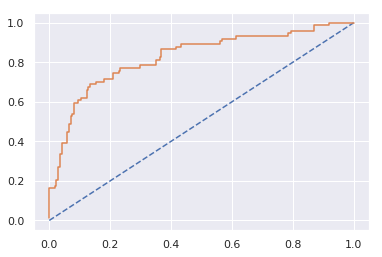

In [15]:
plot_roc_curve(validation, results)

In [16]:
print("ROC AUC:", roc_auc_score(labels, probabilities))

ROC AUC: 0.8251936146672989


## Precision Recall

In [17]:
print("Average precision:", average_precision_score(labels, probabilities))
print("Precision:", precision_score(labels, predictions), "Recall:", recall_score(labels, predictions))

Average precision: 0.7129739278827962
Precision: 0.7543859649122807 Recall: 0.581081081081081


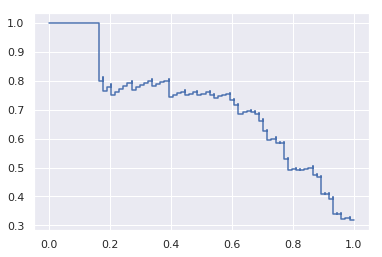

In [18]:
plot_precision_recall(validation, results)

In [19]:
print("PR AUC:", calculate_pr_auc(validation, results))

PR AUC: 0.7106370048185491


## F1 Score

In [20]:
print("F1 score:", f1_score(labels, predictions))

F1 score: 0.6564885496183206


## TSNE

In [21]:
malignancy, modality, category = all_features(features=FEATURES)

In [22]:
tsne_dataset = train

In [23]:
tsne_labels = [category.get(accession_from_filename(f), "unknown") for f in tsne_dataset.filenames]

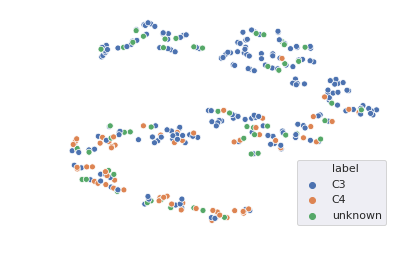

In [24]:
plot_tsne(model, "dense_5", tsne_dataset, tsne_labels, perplexity=5)

## Experts

error with benign/free-27741572-liver.jpeg: '27741572-liver.jpeg'
error with malignant/free-30095075-liver.jpeg: '30095075-liver.jpeg'


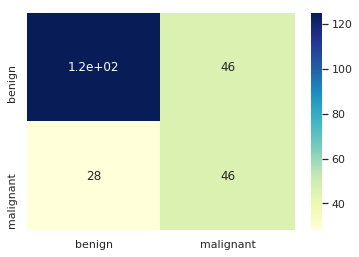

In [25]:
expert_1 = plot_expert_confusion("evaluations/radiology-9809.json", validation)

In [26]:
pandas.DataFrame(expert_1, index=validation.class_indices)

,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
benign,0.698,125,46,28,46,0.731,0.622,0.817,0.500,0.378,0.269,0.183,0.676,0.674
malignant,0.698,46,125,46,28,0.622,0.731,0.500,0.817,0.269,0.378,0.500,0.676,0.674


## ROC with experts

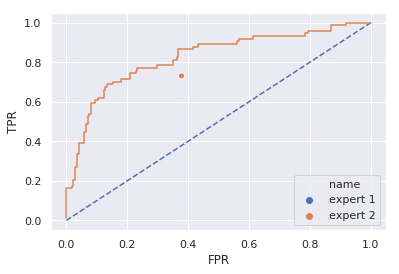

In [27]:
plot_roc_curve(validation, results, experts=[{ **expert_1, "name":"expert 1" }, { **expert_1, "name":"expert 2" }])

## Grad Cam

### benign example

/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


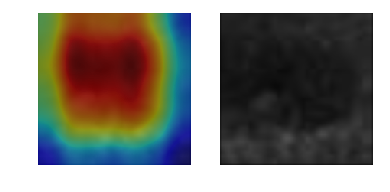

In [28]:
plot_grad_cam(
    os.path.join(validation.directory, validation.filenames[0]), 
    model, 
    "dense_6", 
)

### malignant example

/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/harrison/.local/share/virtualenvs/deep-ultrasound-k5cplrX3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


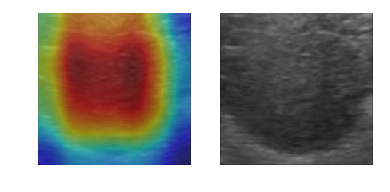

In [29]:
plot_grad_cam(
    os.path.join(validation.directory, validation.filenames[len(validation.filenames) - 1]), 
    model, 
    "dense_6", 
)

In [30]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')